# Проект: Выбор региона для нефтеразработки

## Введение

Компания «ГлавРосГосНефть» занимается добычей нефти. Эффективный выбор места для бурения скважины позволяет максимизировать прибыль и минимизировать риски. В данном исследовании необходимо определить регион, в котором разработка новых скважин будет наиболее прибыльной. Для этого будут применены методы машинного обучения, позволяющие спрогнозировать объём запасов нефти и оценить потенциальную прибыль с учетом возможных рисков.

## Цель исследования

Целью данного исследования является построение модели для прогнозирования запасов нефти в скважинах трёх регионов и определение региона, где добыча принесёт наибольшую прибыль.

## Условия задачи

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Описание данных

Данные геологоразведки находятся в трех таблицах: `geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv`.
Таблицы содержат следующие признаки:
* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три числовых признака скважины;
* `product` — объём запасов нефти в тысячах баррелей, целевой признак.

## План исследования

1 [Загрузка и подготовка данных](#link1):
* [Загрузка данных](#link11)
* [Предобработка данных](#link12)
* [Исследовательский анализ данных](#link13)

2 [Обучение и проверка модели](#link2). Для каждого региона:
* Разделение данных на обучающую и валидационную выборки
* Обучение модели линейной регрессии и предсказание на валидационной выборке
* Сохранение предсказания и правильных ответы на валидационной выборке
* Оценка модели по среднему запасу нефти и RMSE
* Анализ результатов
<br>

3 [Подготовка к расчёту прибыли](#link3):
* Сохранение ключевых значений для расчетов
* Расчет безубыточной разработки
* Вывод по подготовке к расчету
<br>

4 [Расчет прибыли](#link4):
* Выбор 200 лучших скважин по предсказаниям
* Суммирование фактических запасов нефти
* Расчет прибыли
<br>

5 [Анализ рисков](#link5):
* Применение Bootstrap (1000 выборок) для оценки прибыли
* Определение средней прибыли, доверительного интервала и риск убытков
* Выбор наиболее выгодного региона
<br>

[Общий вывод](#link6)

## Подготовка рабочего пространства

In [1]:
# установим необходимые библотеки
!pip install phik -q

In [2]:
# импортируем необходимые библиотеки
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler
)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet
)
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

In [3]:
# отключим все предупреждения о будущем удалении устаревших опций
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# зададим константы
RANDOM_STATE = 42

Функция для визуализации распределения и разброса данных.

In [5]:
def show_plots(df, feature, type='hist', new_bins=0, new_hue=None, title='', quart1=None, quart3=None):
    """
    Выводит в общем окне два графика для визуализации распределения и разброса данных.

    Параметры:
    df (pd.DataFrame): DataFrame с данными.
    feature (str): Название признака для визуализации.
    type (str, optional): 'hist' - Выводит гистограмму и горизонтальную диаграмму размаха.
                                   Используется по умолчанию.
                          'bars' - Выводит cтолбчатую диаграмму частот и горизонтальную диаграмму размаха.
    new_bins (int, optional): Количество корзин для гистограммы. 
                              Если 0, используется значение по умолчанию
                              и происходит автоматический подбор количества корзин.
    new_hue (str, optional): Название признака для категоризации.
                             По умолчанию - None
    title (str, optional):   Дополнение в заголовок.
                             По умолчанию - ''
    quart1 (float, optional):      Дополнительная метка. 
    quart3 (float, optional):      Дополнительная метка.
    """
    
    # Задаем количесво знаков после запятой в зависимости
    if abs(df[feature].max()) > 1000:
        rnd = 0
    elif abs(df[feature].max()) > 100:
        rnd = 1
    elif abs(df[feature].max()) > 10:
        rnd = 2
    elif abs(df[feature].max()) > 1:
        rnd = 3
    else:
        rnd = 4
    
    plt.figure(figsize=(12, 5))

    if type=='hist':
        # Гистограмма
        plt.subplot(1, 2, 1)
        if new_bins == 0:
            sns.histplot(x=feature, data=df.dropna(subset=[feature]), kde=True, color='#a1c9f4', hue=new_hue)
        else:
            sns.histplot(x=feature, data=df.dropna(subset=[feature]), kde=True, color='#a1c9f4', hue=new_hue, bins=new_bins)
        plt.title(f'Гистограмма для {title}')
        plt.xlabel(feature)
        plt.ylabel('Количество')

    elif type=='bars':
        # Столбчатая диаграмма частот
        plt.subplot(1, 2, 1)
        sns.countplot(x=feature, data=df.dropna(subset=[feature]), edgecolor="black", color='#a1c9f4', hue=new_hue)
        plt.title(f'Диаграмма частот для {title}')
        plt.xlabel(feature)
        plt.ylabel('Количество')

    else:
        plt.subplot(1, 2, 1)
        plt.title('Неправильно задан параметр type')

    # Горизонтальная диаграмма размаха (Boxplot)
    plt.subplot(1, 2, 2)
    bp = sns.boxplot(x=df[feature].dropna(), 
                     orient='h', 
                     color='#b5d9ff', 
                     width=0.2)
    bp.set_title(f'Диаграмма размаха для {title}')
    bp.set_xlabel(feature)

    data = df[feature].dropna()

    # Извлечение статистики
    quartiles = np.percentile(data, [25, 50, 75])  # Q1, медиана, Q3
    q1, median, q3 = quartiles
    iqr = q3 - q1
    lower_whisker = max(min(data), q1 - 1.5 * iqr)
    upper_whisker = min(max(data), q3 + 1.5 * iqr)
    outliers = [x for x in data if x < lower_whisker or x > upper_whisker]

    # Подписываем значения через annotate с поворотом текста
    for value, label in zip([q1, median, q3, lower_whisker, upper_whisker],
                            ['Q1', 'Медиана', 'Q3', 'Мин', 'Макс']):
        bp.annotate(f"{label}: {value:.{rnd}f}",
                    xy=(value, 0),
                    xytext=(value, 0.45),
                    textcoords='data',
                    ha='center',
                    fontsize=9,
                    rotation=90)

    if quart1 is not None and quart3 is not None:
        quarts = np.percentile(data, [quart1, quart3])
        quart1_, quart3_ = quarts
        for value, label in zip([quart1_, quart3_],
                            [f'{quart1}%', f'{quart3}%']):
            bp.annotate(f"{label}: {value:.{rnd}f}",
                        xy=(value, 0),
                        xytext=(value, 0.45),
                        textcoords='data',
                        ha='center',
                        fontsize=9,
                        rotation=90)

    # Отметка выбросов
    for outlier in outliers:
        bp.annotate(f"Выброс: {outlier:.{rnd}f}",
                    xy=(outlier, 0),
                    xytext=(outlier, -0.15),
                    textcoords='data',
                    ha='center',
                    fontsize=9,
                    color='red',
                    rotation=90)

    # Добавление среднего значения
    mean_value = data.mean()
    bp.annotate(f"Среднее: {mean_value:.{rnd}f}",
                xy=(mean_value, 0),
                xytext=(mean_value, -0.15),
                textcoords='data',
                ha='center',
                fontsize=9,
                color='blue',
                rotation=90)

    # Добавление количества выбросов
    bp.annotate(f'Количество выбросов: {len(outliers)}',
                xy=(data.min(), -0.45),
                xytext=(data.min(), -0.45),
                textcoords='data',
                ha='left',
                fontsize=10,
                color='purple')

# Настройка цветов линий коробки через Matplotlib
    for line in bp.artists:
        line.set_edgecolor('blue')  # Цвет линий коробки
    
    # Показ графика
    plt.tight_layout()
    plt.show()

In [6]:
def describe_corr_matrix(corr_matrix):
    corr_list = []
    
    for row in corr_matrix.columns:
        for col in corr_matrix.columns:
            if row < col:
                corr_value = corr_matrix.loc[row, col]
                if abs(corr_value) > 0.9:
                    corr_list.append(f"1. Весьма высокая корреляция между {row} и {col}: {corr_value:.3f}")
                elif abs(corr_value) > 0.7:
                    corr_list.append(f"2. Высокая корреляция между {row} и {col}: {corr_value:.3f}")
                elif abs(corr_value) > 0.5:
                    corr_list.append(f"3. Заметная корреляция между {row} и {col}: {corr_value:.3f}")
                elif abs(corr_value) > 0.3:
                    corr_list.append(f"4. Умеренная корреляция между {row} и {col}: {corr_value:.3f}")
                elif abs(corr_value) > 0.1:
                    corr_list.append(f"5. Слабая корреляция между {row} и {col}: {corr_value:.3f}")
    
    corr_list = sorted(corr_list)
    
    return corr_list

<a class='anchor' id="link1"></a>
## 1 Загрузка и подготовка данных

<a class='anchor' id="link11"></a>
### 1.1 Загрузка данных

**1.1.1 Откроем файлы с данными**

In [7]:
file = "geo_data_0.csv"
pth1 = f"{file}"
pth2 = f"https://code.s3.yandex.net/datasets/{file}"

if os.path.exists(pth1):
    geo_data_0_df = pd.read_csv(pth1)
else:
    try:
        geo_data_0_df = pd.read_csv(pth2)
    except Exception as e:
        print(f"Can't find or download '{file}'", e)

In [8]:
file = "geo_data_1.csv"
pth1 = f"{file}"
pth2 = f"https://code.s3.yandex.net/datasets/{file}"

if os.path.exists(pth1):
    geo_data_1_df = pd.read_csv(pth1)
else:
    try:
        geo_data_1_df = pd.read_csv(pth2)
    except Exception as e:
        print(f"Can't find or download '{file}'", e)

In [9]:
file = "geo_data_2.csv"
pth1 = f"{file}"
pth2 = f"https://code.s3.yandex.net/datasets/{file}"

if os.path.exists(pth1):
    geo_data_2_df = pd.read_csv(pth1)
else:
    try:
        geo_data_2_df = pd.read_csv(pth2)
    except Exception as e:
        print(f"Can't find or download '{file}'", e)

Для удобства визуализации и написания выводов дадим каждому региону разработки скважин условное название:<br>
<b>Регион 0 - geo_data_0_df</b><br>
<b>Регион 1 - geo_data_1_df</b><br>
<b>Регион 2 - geo_data_2_df</b>

**1.1.2 Изучим общую информацию о датафреймах**

Выведем первые строки и общую информацию таблицы **geo_data_0_df**.

In [10]:
geo_data_0_df.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [11]:
geo_data_0_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Таблица geo_data_0_df состоит из 100000 строк и 5 столбцов. Пропусков нет. Типы данных соответствуют данным. Стилистика в названиях столбцов соблюдена.

Выведем первые строки и общую информацию таблицы **geo_data_1_df**.

In [12]:
geo_data_1_df.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [13]:
geo_data_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Таблица geo_data_1_df состоит из 100000 строк и 5 столбцов. Пропусков нет. Типы данных соответствуют данным. Стилистика в названиях столбцов соблюдена.

Выведем первые строки и общую информацию таблицы **geo_data_2_df**.

In [14]:
geo_data_2_df.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [15]:
geo_data_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Таблица geo_data_2_df состоит из 100000 строк и 5 столбцов. Пропусков нет. Типы данных соответствуют данным. Стилистика в названиях столбцов соблюдена.

<a class='anchor' id="link12"></a>
### 1.2 Предобработка данных

Поищем дубликаты в таблицах **geo_data_0_df**, **geo_data_1_df**, **geo_data_2_df**.

In [16]:
geo_data_0_df.duplicated().sum()

np.int64(0)

In [17]:
geo_data_1_df.duplicated().sum()

np.int64(0)

In [18]:
geo_data_2_df.duplicated().sum()

np.int64(0)

Полных дубликатов нет.

Поищем дубликаты в столбце **id**

In [19]:
geo_data_0_df['id'].duplicated().sum()

np.int64(10)

In [20]:
geo_data_0_df[geo_data_0_df['id'].duplicated(keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


In [21]:
geo_data_1_df['id'].duplicated().sum()

np.int64(4)

In [22]:
geo_data_1_df[geo_data_1_df['id'].duplicated(keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [23]:
geo_data_2_df['id'].duplicated().sum()

np.int64(4)

In [24]:
geo_data_2_df[geo_data_2_df['id'].duplicated(keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Некоторые скважины имеют дубликаты. Данные в дубликатах сильно отличаются. Определить в каких записях актуальная информация не получится. Предлагается дублированные скважины исключить из анализа.

In [25]:
geo_data_0_df = geo_data_0_df[~geo_data_0_df['id'].duplicated(keep=False)]
geo_data_1_df = geo_data_1_df[~geo_data_1_df['id'].duplicated(keep=False)]
geo_data_2_df = geo_data_2_df[~geo_data_2_df['id'].duplicated(keep=False)]

In [26]:
geo_data_0_df['id'].duplicated().sum()

np.int64(0)

In [27]:
geo_data_1_df['id'].duplicated().sum()

np.int64(0)

In [28]:
geo_data_2_df['id'].duplicated().sum()

np.int64(0)

<a class='anchor' id="link13"></a>
### 1.3 Исследовательский анализ данных

Для понятной визуализации информации запишем название выходного признака на русском языке.

In [29]:
# перевод с английского на русский
eng_to_rus = {
    "product": "Объём запасов в скважине (тыс. баррелей)"
}

# перевод с русского на английский
rus_to_eng = {
    "Объём запасов в скважине (тыс. баррелей)": "product"
}

**1.3.1 Статистический анализ таблицы geo_data_0_df**

Создадим копию датафрейма и переведем его на русский язык.

In [30]:
geo_data_0_df_rus = geo_data_0_df.copy()
geo_data_0_df_rus.rename(columns=eng_to_rus, inplace=True)
geo_data_0_df_rus = geo_data_0_df_rus.replace(eng_to_rus)

Посмотрим статистическое описание данных.

In [31]:
geo_data_0_df_rus.describe(include='all')

,id,f0,f1,f2,Объём запасов в скважине (тыс. баррелей)
count,99980,99980.000000,99980.000000,99980.000000,99980.000000
unique,99980,NaN,NaN,NaN,NaN
top,1CWhH,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,0.500447,0.250147,2.502638,92.499166
std,NaN,0.871879,0.504431,3.248056,44.289044
min,NaN,-1.408605,-0.848218,-12.088328,0.000000
25%,NaN,-0.072674,-0.200869,0.288010,56.496513
50%,NaN,0.502374,0.250252,2.516005,91.847928
75%,NaN,1.073692,0.700646,4.714884,128.564089


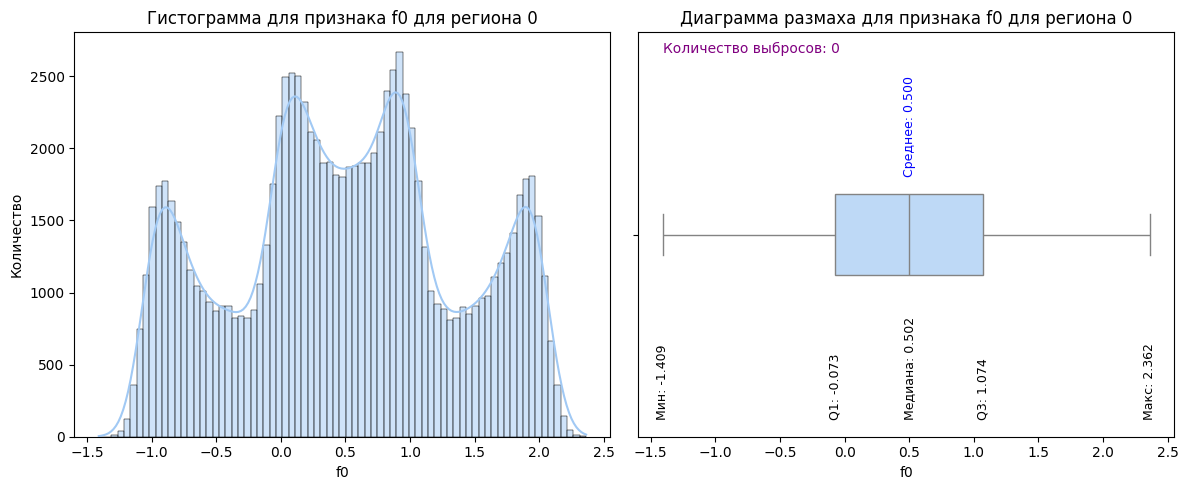

In [32]:
show_plots(geo_data_0_df_rus, 'f0', title='признака f0 для региона 0')

Распределение признака f0 мультимодальное с четырьмя пиками<br>
Данные находятся в диапазоне от -1,409 до 2,362<br>
Среднее значение: 0,500<br>
Медианное значение: 0,502<br>
Межквартильный разброс: от -0,073 до 1,074<br>
Выбросов нет

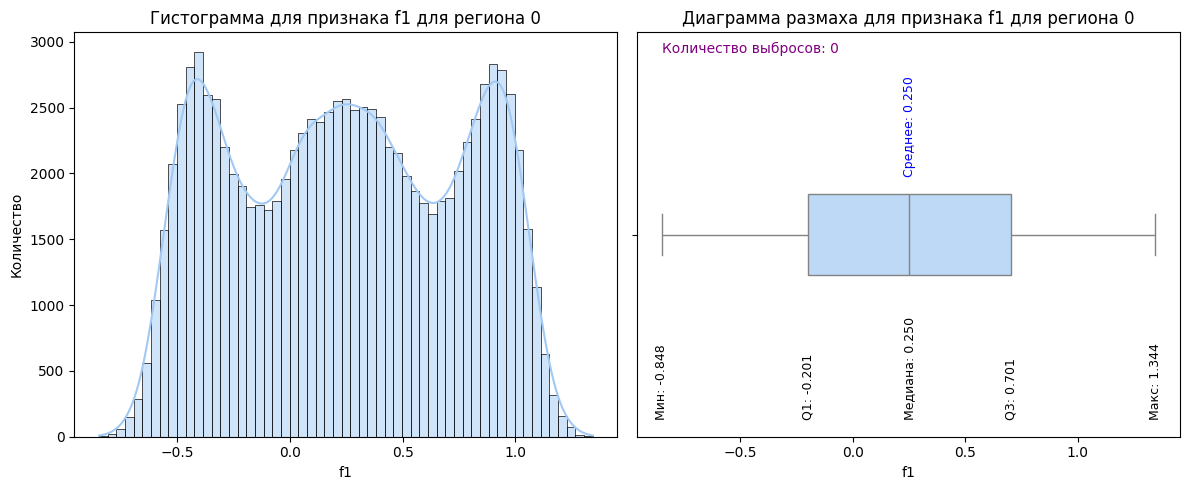

In [33]:
show_plots(geo_data_0_df_rus, 'f1', title='признака f1 для региона 0')

Распределение признака f1 мультимодальное с тремя пиками<br>
Данные находятся в диапазоне от -0,848 до 1,344<br>
Среднее значение: 0,250<br>
Медианное значение: 0,250<br>
Межквартильный разброс: от -0,201 до 0,701<br>
Выбросов нет

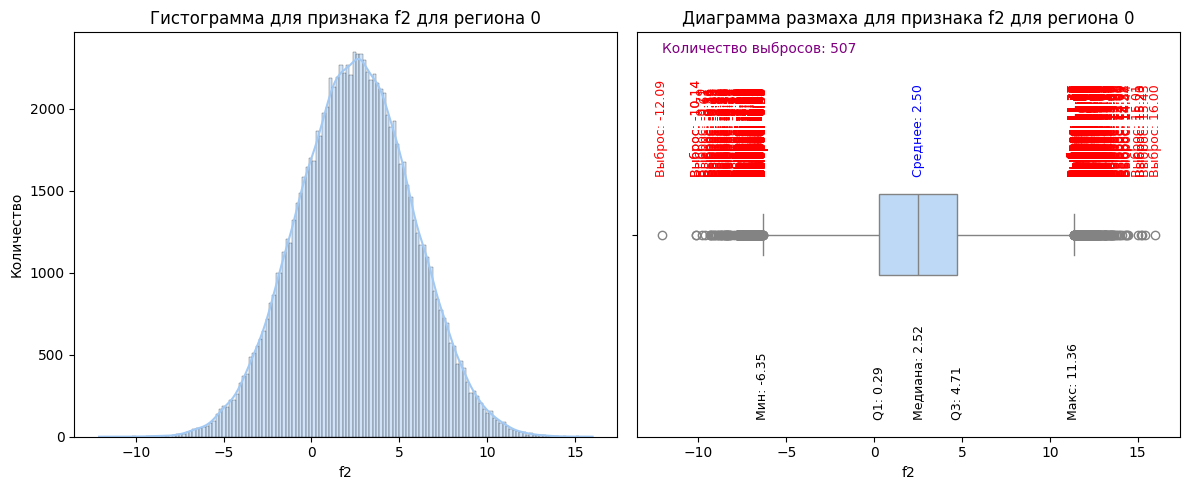

In [34]:
show_plots(geo_data_0_df_rus, 'f2', title='признака f2 для региона 0')

Распределение признака f2 можно считать нормальным<br>
Данные находятся в диапазоне от -12,09 до 16,00<br>
Среднее значение: 2,50<br>
Медианное значение: 2,52<br>
Межквартильный разброс: от 0,29 до 4,71<br>
Данные, не попавшие в диапазон от -6,35 до 11,36, можно условно считать выбросами. Таких выбросов 507.

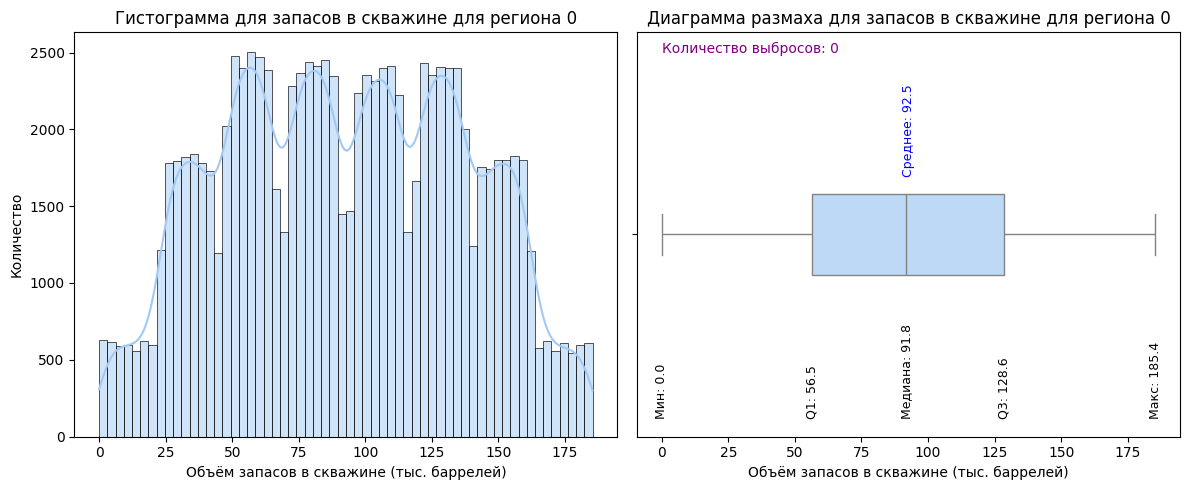

In [35]:
show_plots(geo_data_0_df_rus, 'Объём запасов в скважине (тыс. баррелей)', title='запасов в скважине для региона 0')

Распределение объёмов запасов в скважине мультимодальное<br>
Данные находятся в диапазоне от 0 до 185,4 тыс. баррелей<br>
Среднее значение: 92,5 тыс. баррелей<br>
Медианное значение: 91,8  тыс. баррелей<br>
Межквартильный разброс: от -56,5 до 128,6 тыс. баррелей<br>
Выбросов нет

**1.3.2 Статистический анализ таблицы geo_data_1_df**

Создадим копию датафрейма и переведем его на русский язык.

In [36]:
geo_data_1_df_rus = geo_data_1_df.copy()
geo_data_1_df_rus.rename(columns=eng_to_rus, inplace=True)
geo_data_1_df_rus = geo_data_1_df_rus.replace(eng_to_rus)

Посмотрим статистическое описание данных.

In [37]:
geo_data_1_df_rus.describe(include='all')

,id,f0,f1,f2,Объём запасов в скважине (тыс. баррелей)
count,99992,99992.000000,99992.000000,99992.000000,99992.000000
unique,99992,NaN,NaN,NaN,NaN
top,relB0,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,1.141363,-4.796522,2.494511,68.824148
std,NaN,8.965805,5.119934,1.703587,45.944889
min,NaN,-31.609576,-26.358598,-0.018144,0.000000
25%,NaN,-6.298525,-8.267985,1.000021,26.953261
50%,NaN,1.153190,-4.813005,2.011475,57.085625
75%,NaN,8.620964,-1.332704,3.999904,107.813044


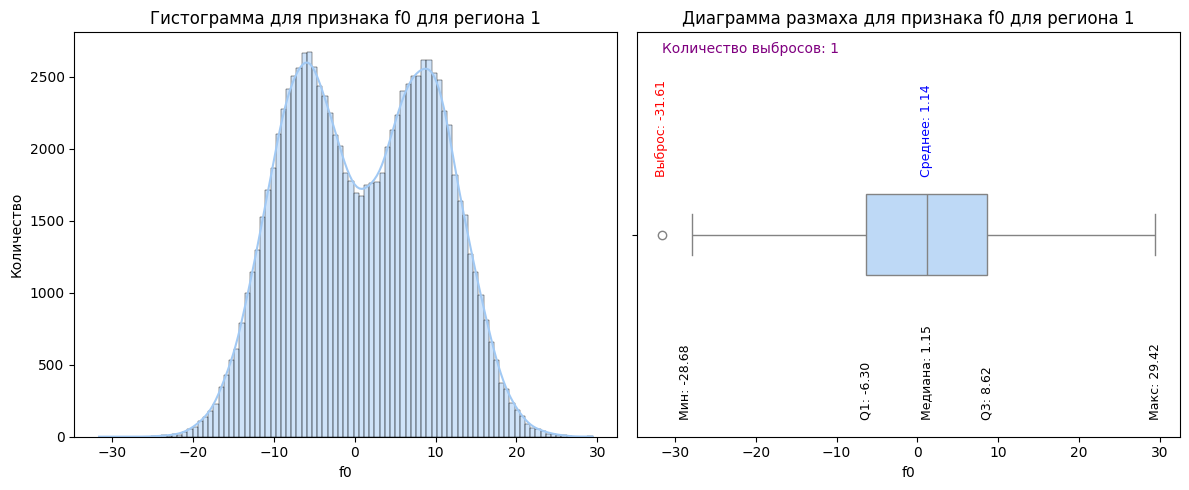

In [38]:
show_plots(geo_data_1_df_rus, 'f0', title='признака f0 для региона 1')

Распределение признака f0 мультимодальное с двумя пиками<br>
Данные находятся в диапазоне от -31,61 до 29,42<br>
Среднее значение: 1,14<br>
Медианное значение: 1,15<br>
Межквартильный разброс: от -6,30 до 8,62<br>
Значения меньше -28,68 можно считать аномально низкими. Такое значение только одно.

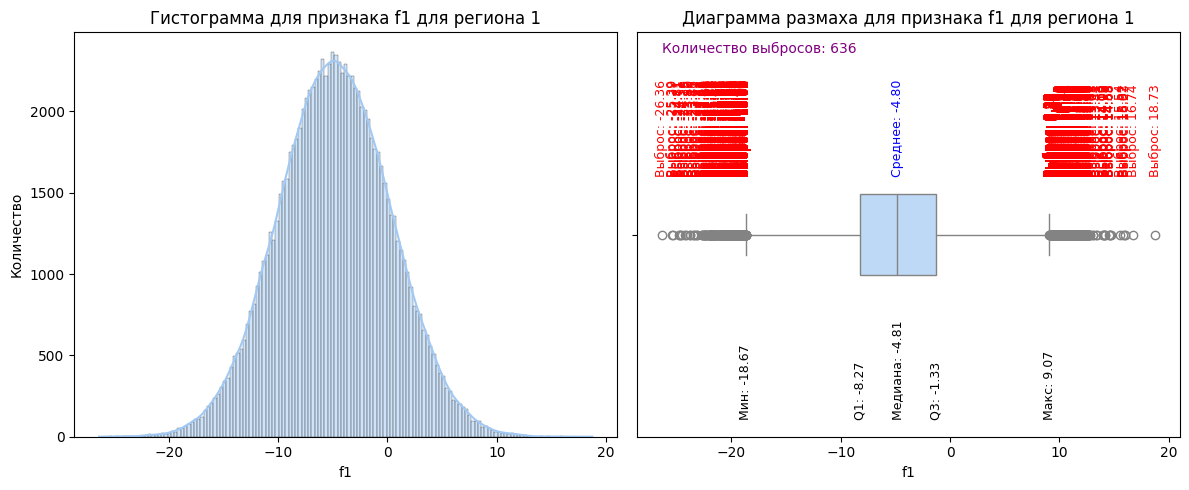

In [39]:
show_plots(geo_data_1_df_rus, 'f1', title='признака f1 для региона 1')

Распределение признака f1 можно считать нормальным<br>
Данные находятся в диапазоне от -26,36 до 18,73<br>
Среднее значение: -4,80<br>
Медианное значение: -4,81<br>
Межквартильный разброс: от -8,27 до 1,33<br>
Данные, не попавшие в диапазон от -18,67 до 9,07, можно условно считать выбросами. Таких выбросов 636.

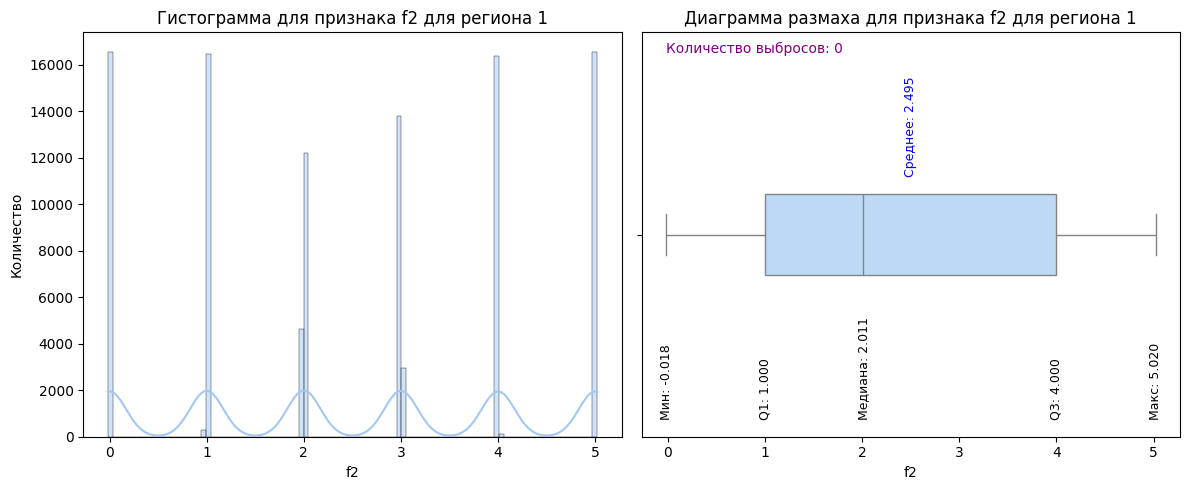

In [40]:
show_plots(geo_data_1_df_rus, 'f2', new_bins=100, title='признака f2 для региона 1')

Данные признака f2 сгруппированы возле шести целых чисел от 0 до 5<br>
Данные находятся в диапазоне от 0,018 до 5,020<br>
Среднее значение: 2,495<br>
Медианное значение: 2,011<br>
Межквартильный разброс: от 1,000 до 4,000<br>
Выбросов нет

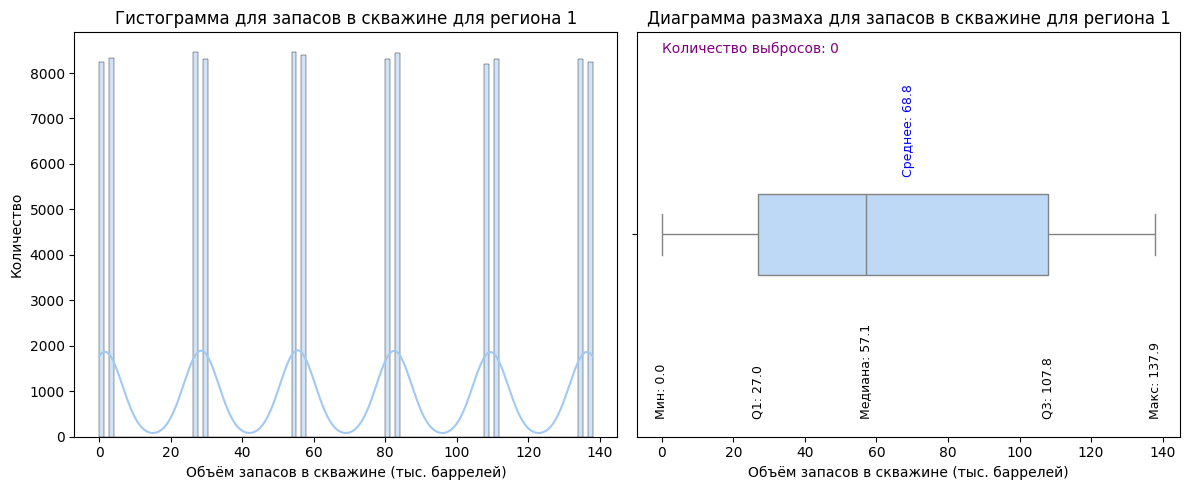

In [41]:
show_plots(geo_data_1_df_rus, 'Объём запасов в скважине (тыс. баррелей)', new_bins=100, title='запасов в скважине для региона 1')

In [42]:
len(geo_data_1_df_rus['Объём запасов в скважине (тыс. баррелей)'].unique())

12

In [43]:
sorted(geo_data_1_df_rus['Объём запасов в скважине (тыс. баррелей)'].unique())

[np.float64(0.0),
 np.float64(3.179102583207246),
 np.float64(26.95326103153969),
 np.float64(30.132363614746943),
 np.float64(53.90652206307938),
 np.float64(57.08562464628662),
 np.float64(80.85978309461906),
 np.float64(84.03888567782631),
 np.float64(107.81304412615876),
 np.float64(110.992146709366),
 np.float64(134.76630515769844),
 np.float64(137.94540774090564)]

Данные выходного признака имеют только 12 уникальных значений.<br>
Объемы запасов нефти в скважинах изменяются в диапазоне от 0 до 137,9 тыс. баррелей.<br>
Каждому значению объема запасов нефти соответствуют около 8 тыс. скважин.

**1.3.3 Статистический анализ таблицы geo_data_2_df**

Создадим копию датафрейма и переведем его на русский язык.

In [44]:
geo_data_2_df_rus = geo_data_2_df.copy()
geo_data_2_df_rus.rename(columns=eng_to_rus, inplace=True)
geo_data_2_df_rus = geo_data_2_df_rus.replace(eng_to_rus)

Посмотрим статистическое описание данных.

In [45]:
geo_data_2_df_rus.describe(include='all')

,id,f0,f1,f2,Объём запасов в скважине (тыс. баррелей)
count,99992,99992.000000,99992.000000,99992.000000,99992.000000
unique,99992,NaN,NaN,NaN,NaN
top,V9kWn,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,0.001975,-0.002113,2.495088,94.998767
std,NaN,1.732061,1.730404,3.473491,44.747763
min,NaN,-8.760004,-7.084020,-11.970335,0.000000
25%,NaN,-1.162328,-1.174820,0.130269,59.450441
50%,NaN,0.009411,-0.009580,2.484236,94.925026
75%,NaN,1.158442,1.163592,4.858662,130.585544


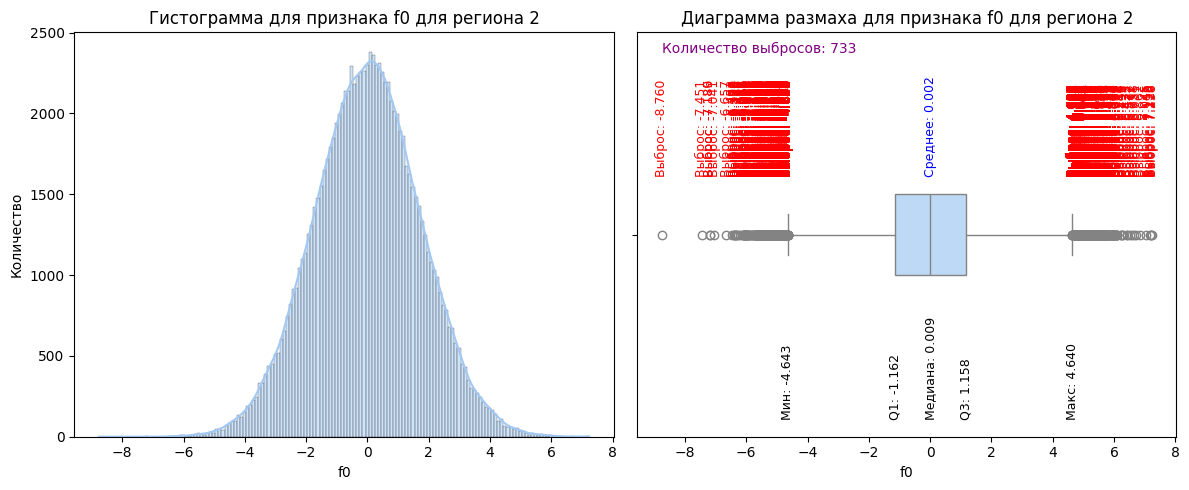

In [46]:
show_plots(geo_data_2_df_rus, 'f0', title='признака f0 для региона 2')

Распределение признака f0 можно считать нормальным<br>
Данные находятся в диапазоне от -8,760 до 7,238<br>
Среднее значение: 0,002<br>
Медианное значение: 0,009<br>
Межквартильный разброс: от -1,162 до 1,158<br>
Данные, не попавшие в диапазон от -4,643 до 4,640, можно условно считать выбросами. Таких выбросов 733.

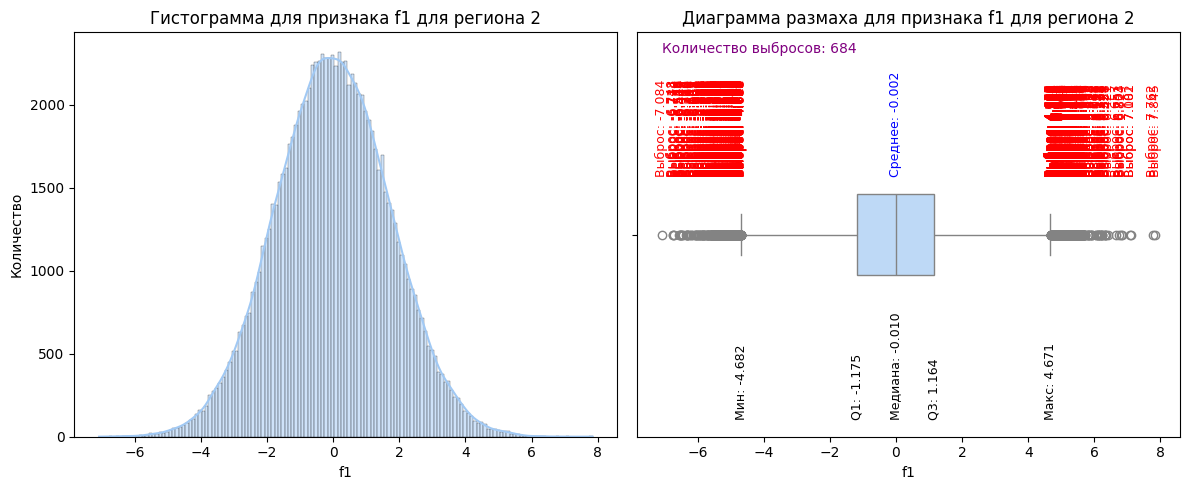

In [47]:
show_plots(geo_data_2_df_rus, 'f1', title='признака f1 для региона 2')

Распределение признака f1 можно считать нормальным<br>
Данные находятся в диапазоне от -7,084 до 7,845<br>
Среднее значение: 0,002<br>
Медианное значение: 0,010<br>
Межквартильный разброс: от -1,175 до 1,164<br>
Данные, не попавшие в диапазон от -4,682 до 4,671, можно условно считать выбросами. Таких выбросов 684.

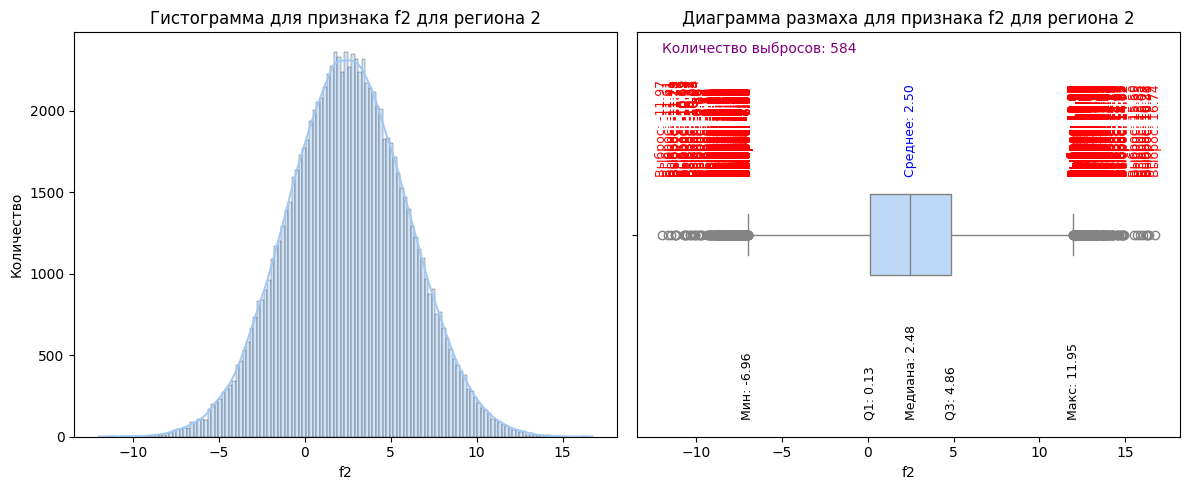

In [48]:
show_plots(geo_data_2_df_rus, 'f2', title='признака f2 для региона 2')

Распределение признака f2 можно считать нормальным<br>
Данные находятся в диапазоне от -11,97 до 16,74<br>
Среднее значение: 2,50<br>
Медианное значение: 2,48<br>
Межквартильный разброс: от 0,13 до 4,86<br>
Данные, не попавшие в диапазон от -6,96 до 11,95, можно условно считать выбросами. Таких выбросов 584.

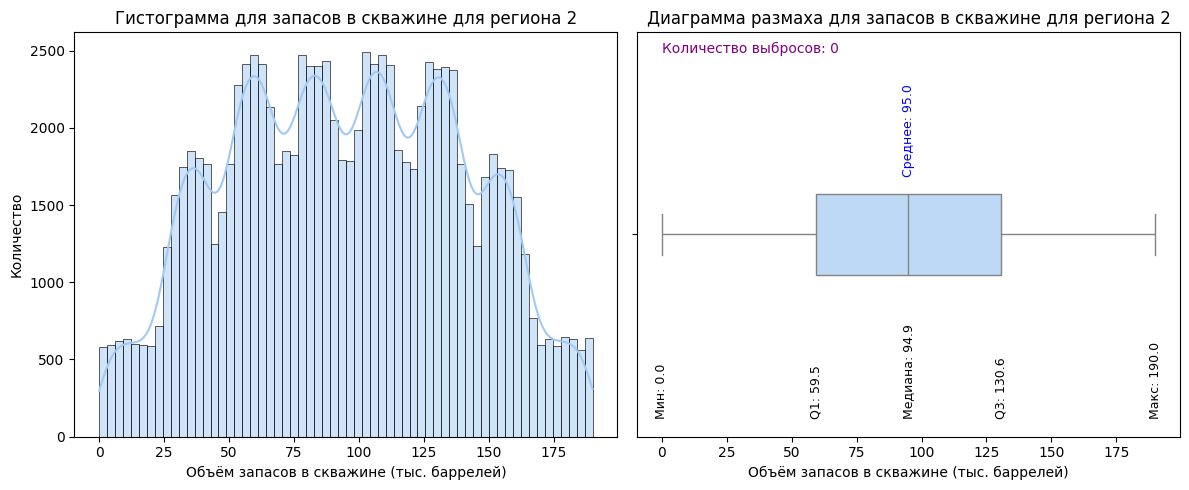

In [49]:
show_plots(geo_data_2_df_rus, 'Объём запасов в скважине (тыс. баррелей)', title='запасов в скважине для региона 2')

Распределение объёмов запасов в скважине мультимодальное<br>
Данные находятся в диапазоне от 0 до 190,0 тыс. баррелей<br>
Среднее значение: 95,0 тыс. баррелей<br>
Медианное значение: 94,9  тыс. баррелей<br>
Межквартильный разброс: от 59,5 до 130,6 тыс. баррелей<br>
Выбросов нет

**1.3.4 Корреляционный анализ данных**

In [50]:
#категориальные непрерывные признаки
num_continuous_features = ['f0', 'f1', 'f2', 'Объём запасов в скважине (тыс. баррелей)']

Проведем корреляционный анализ данных таблицы **geo_data_0_df**.

In [51]:
geo_data_0_df_rus_corr_matrix = geo_data_0_df_rus.drop(columns=['id']).phik_matrix(interval_cols=num_continuous_features)
geo_data_0_df_rus_corr_matrix

,f0,f1,f2,Объём запасов в скважине (тыс. баррелей)
f0,1.000000,0.762204,0.00000,0.215521
f1,0.762204,1.000000,0.00000,0.253536
f2,0.000000,0.000000,1.00000,0.475860
Объём запасов в скважине (тыс. баррелей),0.215521,0.253536,0.47586,1.000000


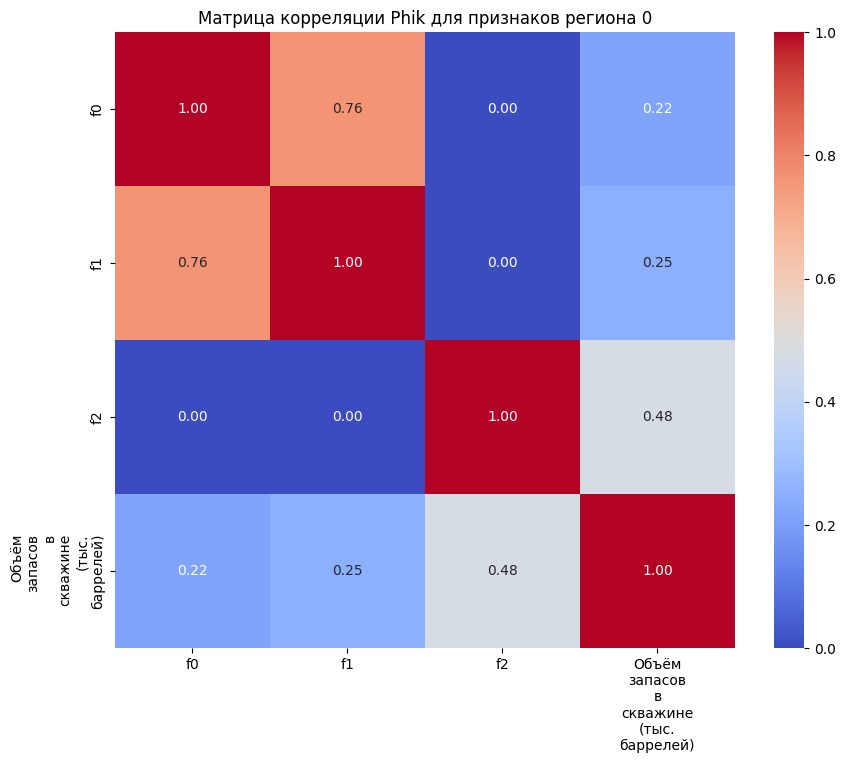

In [52]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    geo_data_0_df_rus_corr_matrix.rename(index=lambda x: x.replace(' ', '\n'), columns=lambda x: x.replace(' ', '\n')), 
    annot=True, cmap='coolwarm', 
    fmt=".2f")
plt.title("Матрица корреляции Phik для признаков региона 0")
plt.show()

In [53]:
geo_data_0_corr_list = describe_corr_matrix(geo_data_0_df_rus_corr_matrix)
geo_data_0_corr_list

['2. Высокая корреляция между f0 и f1: 0.762',
 '4. Умеренная корреляция между f2 и Объём запасов в скважине (тыс. баррелей): 0.476',
 '5. Слабая корреляция между f0 и Объём запасов в скважине (тыс. баррелей): 0.216',
 '5. Слабая корреляция между f1 и Объём запасов в скважине (тыс. баррелей): 0.254']

Проведем корреляционный анализ данных таблицы **geo_data_1_df**.

In [54]:
geo_data_1_df_rus_corr_matrix = geo_data_1_df_rus.drop(columns=['id']).phik_matrix(interval_cols=num_continuous_features)
geo_data_1_df_rus_corr_matrix

,f0,f1,f2,Объём запасов в скважине (тыс. баррелей)
f0,1.000000,0.196055,0.000000,0.628474
f1,0.196055,1.000000,0.000000,0.185931
f2,0.000000,0.000000,1.000000,0.978936
Объём запасов в скважине (тыс. баррелей),0.628474,0.185931,0.978936,1.000000


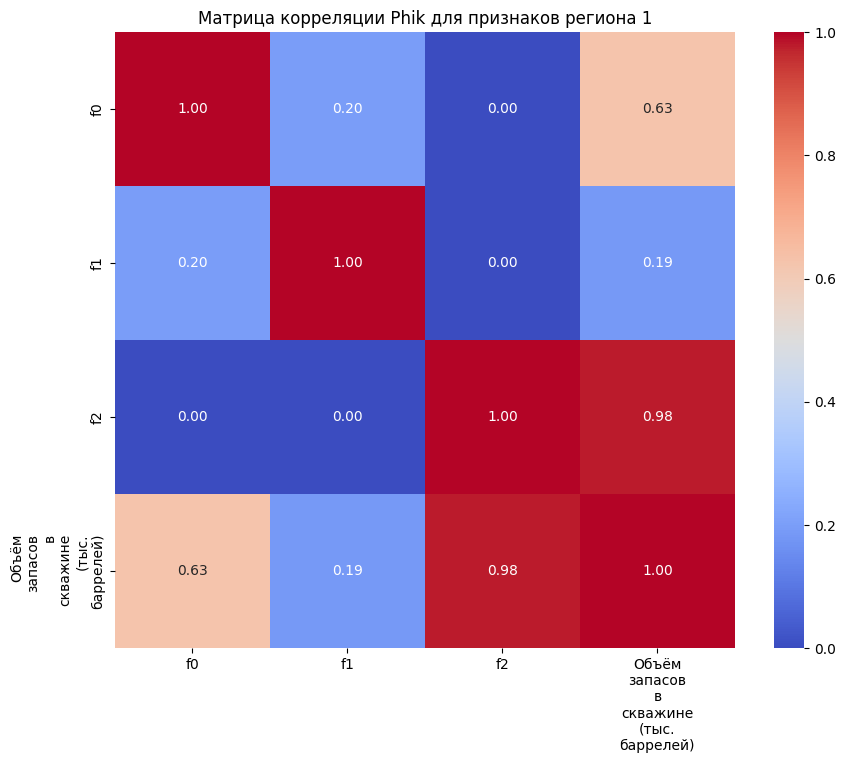

In [55]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    geo_data_1_df_rus_corr_matrix.rename(index=lambda x: x.replace(' ', '\n'), columns=lambda x: x.replace(' ', '\n')), 
    annot=True, cmap='coolwarm', 
    fmt=".2f")
plt.title("Матрица корреляции Phik для признаков региона 1")
plt.show()

In [56]:
geo_data_1_corr_list = describe_corr_matrix(geo_data_1_df_rus_corr_matrix)
geo_data_1_corr_list

['1. Весьма высокая корреляция между f2 и Объём запасов в скважине (тыс. баррелей): 0.979',
 '3. Заметная корреляция между f0 и Объём запасов в скважине (тыс. баррелей): 0.628',
 '5. Слабая корреляция между f0 и f1: 0.196',
 '5. Слабая корреляция между f1 и Объём запасов в скважине (тыс. баррелей): 0.186']

Проведем корреляционный анализ данных таблицы **geo_data_2_df**.

In [57]:
geo_data_2_df_rus_corr_matrix = geo_data_2_df_rus.drop(columns=['id']).phik_matrix(interval_cols=num_continuous_features)
geo_data_2_df_rus_corr_matrix

,f0,f1,f2,Объём запасов в скважине (тыс. баррелей)
f0,1.00000,0.00000,0.000000,0.201070
f1,0.00000,1.00000,0.000000,0.221030
f2,0.00000,0.00000,1.000000,0.443283
Объём запасов в скважине (тыс. баррелей),0.20107,0.22103,0.443283,1.000000


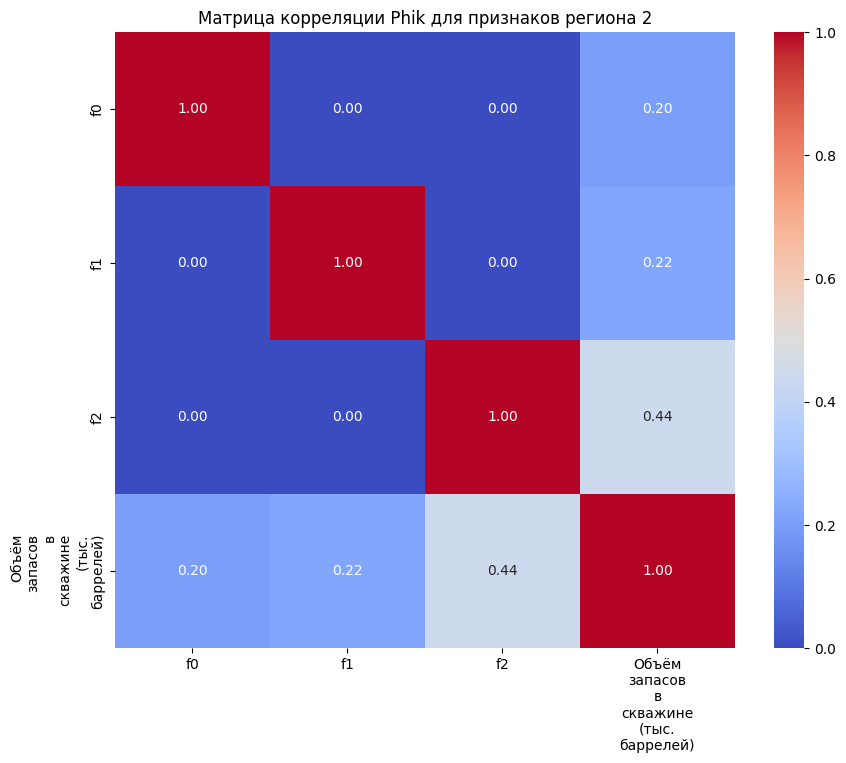

In [58]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    geo_data_2_df_rus_corr_matrix.rename(index=lambda x: x.replace(' ', '\n'), columns=lambda x: x.replace(' ', '\n')), 
    annot=True, cmap='coolwarm', 
    fmt=".2f")
plt.title("Матрица корреляции Phik для признаков региона 2")
plt.show()

In [59]:
geo_data_2_corr_list = describe_corr_matrix(geo_data_2_df_rus_corr_matrix)
geo_data_2_corr_list

['4. Умеренная корреляция между f2 и Объём запасов в скважине (тыс. баррелей): 0.443',
 '5. Слабая корреляция между f0 и Объём запасов в скважине (тыс. баррелей): 0.201',
 '5. Слабая корреляция между f1 и Объём запасов в скважине (тыс. баррелей): 0.221']

**Промежуточный итог:**

Предоставленные таблицы были загружены. Изучена общая информация о данных.<br>
Данные исследованы на наличие пропусков и дубликатов. Проведена предобработка данных.<br>
Проведен статистический анализ данных. Статистические данные визуализированы.<br>
Рассчитаны матрицы корреляций и определены уровни корреляций между признаками.<br>

<a class='anchor' id="link2"></a>
## 2 Обучение и проверка модели

**2.1 Создание пайплайна**

In [60]:
# Количественные признаки:
num_columns = ["f0", "f1", "f2"]
# Целевой признак
target_feature = "product"

Создадим пайплайн для подготовки данных.

In [61]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Создадим итоговый пайплайн: подготовка данных и модель.

In [62]:
pipe_final = Pipeline(
    [
        ('preprocessor', 
         data_preprocessor
        ),
        ('models', 
        LinearRegression()
        )
    ]
)

Для обучения будем использовать модели линейной регрессии LinearRegression, Lasso, Ridge и ElasticNet.

Для перебора моделей, гиперпараметров и методов масштабирования создадим сетку для перебора.

In [63]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': [0.01, 0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': [0.01, 0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [ElasticNet(random_state=RANDOM_STATE)],
        'models__alpha': [0.01, 0.1, 1, 10],
        'models__l1_ratio': [0.1, 0.5, 0.9],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Проверим наличие новых явных дубликатов после удаления столбца 'id'

In [64]:
geo_data_0_df.drop(['id'], axis=1).duplicated().sum()

np.int64(0)

In [65]:
geo_data_1_df.drop(['id'], axis=1).duplicated().sum()

np.int64(0)

In [66]:
geo_data_2_df.drop(['id'], axis=1).duplicated().sum()

np.int64(0)

Новых явных дубликатов нет.

Разделим данные на тренировочные и тестовые и запустим GridSearchCV для поиска лучших моделей и гиперпараметров. 

Для оценки качества моделей будем использовать метрику RMSE.

In [67]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error',  
    n_jobs=-1  
)

regions = [geo_data_0_df, 
           geo_data_1_df, 
           geo_data_2_df]

best_models = []
predictions = []

for i, region in enumerate(regions):
    
    X = region.drop(['id', 'product'], axis=1)
    y = region['product']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    
    print(f'\n                     Регион {i}\n')
    
    # Запустим GridSearchCV для поиска лучших моделей и гиперпараметров.
    grid.fit(X_train, y_train)

    #
    y_test_pred = grid.best_estimator_.predict(X_test)
    predictions.append(y_test_pred)
    best_models.append(grid.best_estimator_)
    region['product_pred'] = grid.best_estimator_.predict(X)
    
    # Выведем параметры и метрику лучшей модели, средний запас нефти
    print(f'Лучшая модель и её параметры:\n {grid.best_estimator_}')
    print(f'\nМетрика RMSE для лучшей модели: {-grid.best_score_:.2f} тыс. баррелей') 
    
    # Оцениваем модель на тестовом наборе
    test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
    print(f"Метрика RMSE на валидационной выборке: {test_rmse:.2f} тыс. баррелей")
    
    # Сравним полученную модель с DummyRegressor
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(X_train, y_train)
    y_pred_dummy = dummy.predict(X_test)
    test_dummy_rmse = np.sqrt(np.mean((y_test - y_pred_dummy) ** 2))
    print(f"Метрика RMSE для DummyRegressor: {test_dummy_rmse:.2f} тыс. баррелей")
    
    # Cредний запас нефти
    print(f'Средний запас сырья: \n    {y_test.mean():.2f} тыс. баррелей')  
    print(f'Средний предсказанный запас сырья: \n    {y_test_pred.mean():.2f} тыс. баррелей')
    print('______________________________________________________________\n')


                     Регион 0

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', Ridge(alpha=0.1, random_state=42))])

Метрика RMSE для лучшей модели: 37.67 тыс. баррелей
Метрика RMSE на валидационной выборке: 37.76 тыс. баррелей
Метрика RMSE для DummyRegressor: 44.26 тыс. баррелей
Средний запас сырья: 
    92.37 тыс. баррелей
Средний предсказанный запас сырья: 
    92.29 тыс. баррелей
______________________________________________________________


                     Регион 1

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['f0', 'f1', 'f2'])

**Промежуточный итог:**

Для региона 1 лучшее значение метрики RMSE на валидационной выборке 0,89 тыс. баррелей. Средний предсказанный запас сырья 69.17 тыс. баррелей. Модель хорошо справилась с предсказаниями. Это связано с весьма высокой корреляцией между f2 и объём запасов в скважине.


Для региона 0 лучшее значение метрики RMSE на валидационной выборке 37.76 тыс. баррелей. Средний предсказанный запас сырья 92,29 тыс. баррелей.
Для региона 2 лучшее значение метрики RMSE на валидационной выборке 40.13 тыс. баррелей. Средний предсказанный запас сырья 94,82 тыс. баррелей.

Для регионов 0 и 2 модели справились с предсказаниями плохо, но немного лучше, чем DummyRegressor, что является следствием низкой корреляции между входными и целевым признаком в датасетах данных регионов.

<a class='anchor' id="link3"></a>
## 3 Подготовка к расчёту прибыли

Введем все ключевые переменые для расчета.

In [68]:
budget = 10_000_000_000
wells_explored = 500
wells_choosed = 200
price = 450_000

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [69]:
volume = budget /(wells_choosed * price)
print(f'Минимальный средний объём сырья для безубыточной разработки новой скважины равен {volume:.2f} тыс. баррелей')

Минимальный средний объём сырья для безубыточной разработки новой скважины равен 111.11 тыс. баррелей


Сравним полученный объём сырья со средним запасом в каждом регионе.

In [70]:
for i, region in enumerate(regions):
    print(f"Средний запас сырья в регионе {i}: {region['product'].mean():.2f} тыс. баррелей, что меньше чем минимальный требуемый запас на {volume-region['product'].mean():.2f} тыс. баррелей")

Средний запас сырья в регионе 0: 92.50 тыс. баррелей, что меньше чем минимальный требуемый запас на 18.61 тыс. баррелей
Средний запас сырья в регионе 1: 68.82 тыс. баррелей, что меньше чем минимальный требуемый запас на 42.29 тыс. баррелей
Средний запас сырья в регионе 2: 95.00 тыс. баррелей, что меньше чем минимальный требуемый запас на 16.11 тыс. баррелей


**Промежуточный итог:**

Для безубыточной разработки новой скважины ее запас сырья должен быть в среднем не менее 111.11 тыс. баррелей.

Средние запасы сырья в представленных регионах меньше данной величины.

<a class='anchor' id="link4"></a>
## 4 Расчет прибыли

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели. Для расчета прибыли используем реальные значения целевого признака.

In [71]:
def predicted_profit(df, price, budge, top=200):
    best_wells = df.sort_values('product_pred', ascending=False).iloc[:top]
    revenue = best_wells['product'].sum() * price
    profit = revenue - budget
    return profit

Выберем по 200 скважин с максимальными значениями предсказаний в каждом регионе. Просуммируем объём сырья и посчитаем прибыль. 

In [72]:
predicted_profits = []

for i, region in enumerate(regions):
    profit = predicted_profit(region, price, budget)
    predicted_profits.append(profit)
    print(f"Прогнозируемая прибыль для 200 лучших скважин региона {i}: {profit:_.0f} рублей".replace("_", " "))

Прогнозируемая прибыль для 200 лучших скважин региона 0: 3 521 042 648 рублей
Прогнозируемая прибыль для 200 лучших скважин региона 1: 2 415 086 697 рублей
Прогнозируемая прибыль для 200 лучших скважин региона 2: 2 555 578 578 рублей


**Промежуточный итог:**

Написана функция для расчета прибыли. Наиболее прибыльными являются 200 лучших скважин в регионе 0.

<a class='anchor' id="link5"></a>
## 5 Анализ рисков

Посчитаем риски и прибыль для каждого региона.

In [73]:
state = np.random.RandomState(RANDOM_STATE)
values_df = pd.DataFrame()

for i, region in enumerate(regions):
    values = []
    
    for j in range(1000):
        subsample = region.sample(wells_explored, replace=True, random_state=state)
        values.append(predicted_profit(subsample, price, budget))
    
    values = pd.Series(values)
    values_df[i] = values
    
    # Статистика
    medium = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    loss_probability = values_df[values_df[i]<0][i].count() / 1000
    
    print(f"Регион {i}:")
    print(f"Средняя прибыль: {medium:,.0f} рублей".replace(",", " "))
    print(f"           2.5%: {lower:,.0f} рублей".replace(",", " "))
    print(f"          97.5%: {upper:,.0f} рублей".replace(",", " "))
    print(f"Вероятность убытков: {loss_probability*100:,.1f}%\n".replace(",", " "))

Регион 0:
Средняя прибыль: 425 676 816 рублей
           2.5%: -82 379 906 рублей
          97.5%: 930 569 957 рублей
Вероятность убытков: 5.5%

Регион 1:
Средняя прибыль: 444 726 851 рублей
           2.5%: 57 428 456 рублей
          97.5%: 855 150 646 рублей
Вероятность убытков: 1.2%

Регион 2:
Средняя прибыль: 368 985 341 рублей
           2.5%: -109 901 240 рублей
          97.5%: 880 793 815 рублей
Вероятность убытков: 6.9%



In [74]:
values_df.columns = ['Регион 0', 'Регион 1', 'Регион 2']

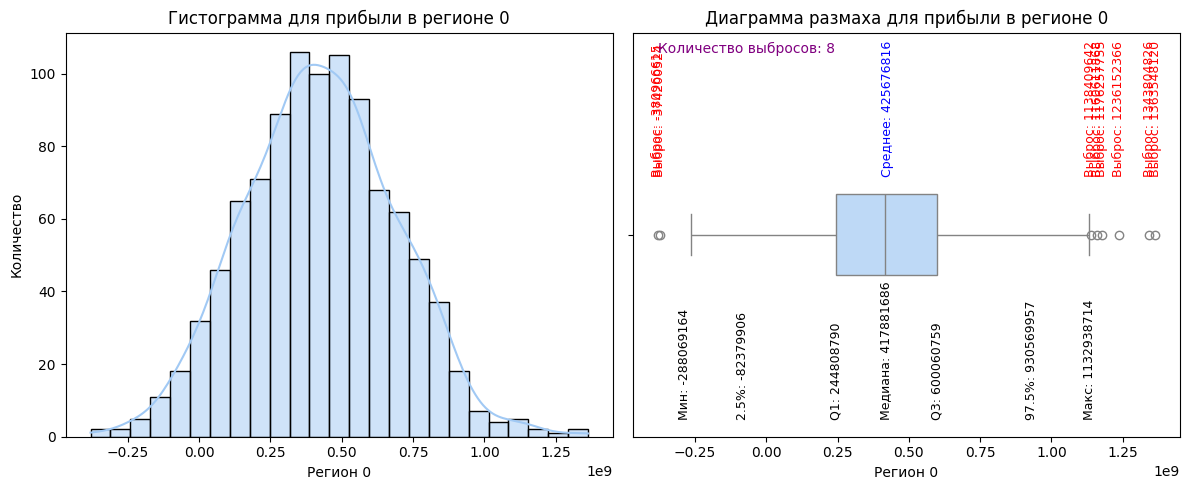

In [75]:
show_plots(values_df, 'Регион 0', title='прибыли в регионе 0', quart1=2.5, quart3=97.5)

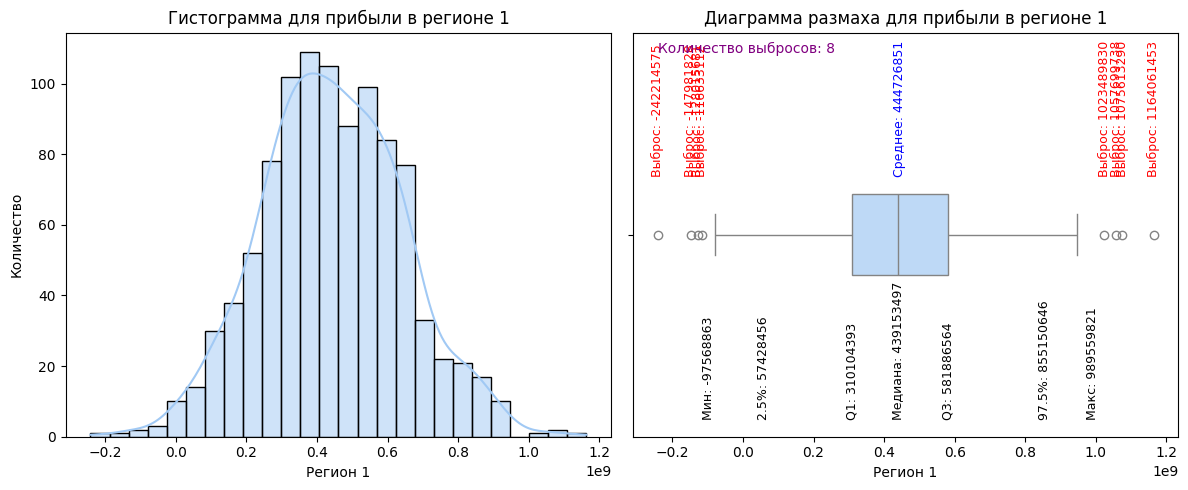

In [76]:
show_plots(values_df, 'Регион 1', title='прибыли в регионе 1', quart1=2.5, quart3=97.5)

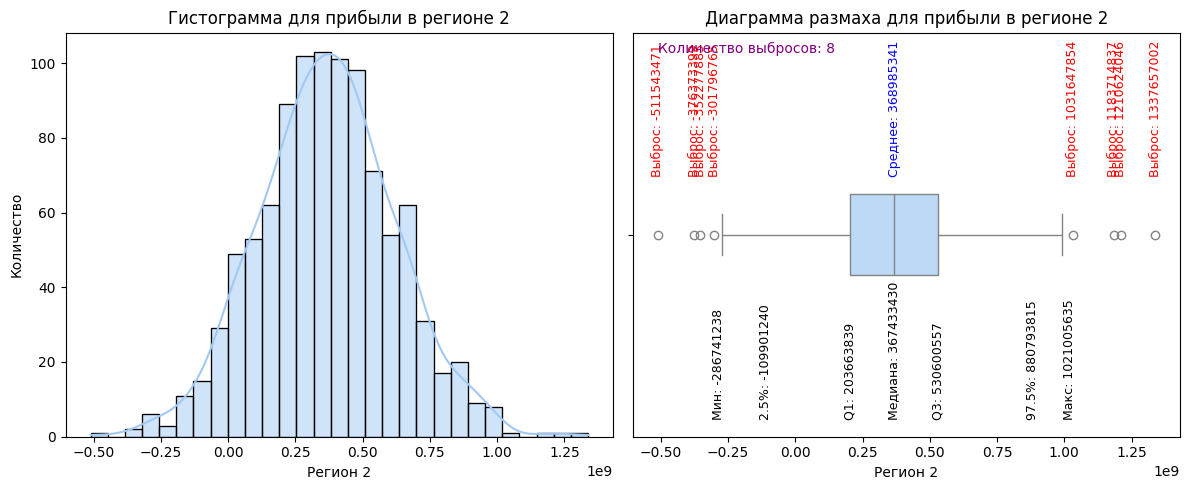

In [77]:
show_plots(values_df, 'Регион 2', title='прибыли в регионе 2', quart1=2.5, quart3=97.5)

**Промежуточный итог:**

В регионе 1 самая высокая средняя прибыль и самая низкая вероятность убытков, ниже требуемых 2.5%.<br>
Средняя прибыль: 444,7 млн. рублей<br>
Медианная прибыль: 439,2 млн. рублей<br>
Межквартильный размах: от 203,7 млн. рублей до 530,6 млн. рублей<br>
Доверительный интервал 95%: от 57,4 млн. рублей до 855,2 млн. рублей<br>
Вероятность убытков: 1.2%

Вероятность убытков для регионов 0 и 2 составила 5.5% и 6.9% соответственно. Эти регионы не подходят для разработки.

<a class='anchor' id="link6"></a>
## Общий вывод

**Целью исследования** было определение наиболее прибыльного региона для разработки новых скважин.

В ходе исследования были проведены следующие работы:
* Предоставленные таблицы были загружены. Изучена общая информация о данных.
* Данные исследованы на наличие пропусков и дубликатов. Проведена предобработка данных.
* Проведен статистический анализ данных. Статистические данные визуализированы.
* Рассчитаны матрицы корреляций и определены уровни корреляций между признаками.
* Проведено обучение моделей линейной регрессии с подбором гиперпараметров.
* Рассчитана прибыль и риски убытков.

**Результаты исследования:**

1. Модели для предсказания объёма запасов нефти:

В регионе 1 модель показала наилучшие результаты: RMSE составило 0,89 тыс. баррелей, а средний предсказанный запас нефти — 69,17 тыс. баррелей. Высокая точность предсказаний связана с весьма высокой корреляцией входного и целевого признаков.<br>
В регионах 0 и 2 результаты оказались значительно хуже, с RMSE 37,76 тыс. баррелей для региона 0 и 40,13 тыс. баррелей для региона 2. Модели в этих регионах справились с задачей немного лучше, чем простое предсказание средней величины, что связано с низкой корреляцией между входными признаками и целевым значением.

2. Безубыточная разработка:

Для безубыточной разработки новой скважины ее запас сырья должен быть в среднем не менее 111,11 тыс. баррелей. Средние запасы нефти в рассматриваемых регионах оказались ниже этой отметки. Это означает, что безубыточная разработка в этих регионах возможна только при правильном отборе скважин.


3. Оценка прибыли и рисков:

В регионе 1 самая высокая средняя прибыль (более 444 млн. рублей) и самая низкая вероятность убытков 1.2% (ниже критической планки в 2,5%, установленной в задаче).

Вероятность убытков для регионов 0 и 2 преодолела порог в 2,5% и составила 5.5% и 6.9% соответственно.

4. Рекомендации:
   
На основе проведенного исследования для разработки рекомендуется выбрать регион 1. Только этот регион обеспечивает наибольшую прибыль при наименьших рисках.
